<a href="https://colab.research.google.com/github/qubvel/transformers-notebooks/blob/main/notebooks/SigLIP2_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SigLIP2 inference

SigLIP 2 is a zero-shot image classification model (similar to SigLIP) proposed in [SigLIP 2: Multilingual Vision-Language Encoders with Improved Semantic Understanding, Localization, and Dense Features]() by Michael Tschannen et al.

In summary, the SigLIP 2 models release includes the following model families:  
- **Fixed-resolution SigLIP 2 variant ("FixRes")**: This variant is designed to be backward-compatible and is based on the same architecture as SigLIP. It allows existing users to simply swap out the model weights and tokenizer (now **multilingual**) to achieve improvements across a wide range of tasks.  
- **Flexible-resolution SigLIP 2 variant ("NaFlex")**: This variant supports variable image resolutions and **preserves the native aspect ratio**. It has the potential to enhance aspect-sensitive applications, such as document understanding.  

Here is a paper abstract:

*We introduce SigLIP 2, a family of new multilingual vision-language encoders that build on the success
of the original SigLIP. In this second iteration, we extend the original image-text training objective with
several prior, independently developed techniques into a unified recipe—this includes decoder-based
pretraining, self-supervised losses (self-distillation, masked prediction) and online data curation. With
these changes, SigLIP 2 models outperform their SigLIP counterparts at all model scales in core capabilities,
including zero-shot classification (best SigLIP 2 ViT-g/16 achieves 85.0% ImageNet zero-shot
accuracy), image-text retrieval, and transfer performance when extracting visual representations for
Vision-Language Models (VLMs). Furthermore, the new training recipe leads to significant improvements
on localization and dense prediction tasks. We also train variants which support multiple resolutions
and preserve the input’s native aspect ratio. Finally, we train on a more diverse data-mixture that
includes de-biasing techniques, leading to much better multilingual understanding and improved fairness.
To provide users with the ability to trade-off inference cost with performance, we release model
checkpoints at four sizes (ViT-B/86M, L/303M, So400m/400M, and g/1B)*

**In this notebook we will cover:**

  - Inference with **FixRes** SigLIP 2
  - Inference with **NaFlex** SigLIP 2
    - Compare FixRes and NaFlex
    - High resolution inference with NaFlex

Let's ensure we have the latest version of transformers installed:

In [ ]:
!pip install pandas requests Pillow
!pip install -q -U git+https://github.com/huggingface/transformers

In [ ]:
import torch
import requests
import pandas as pd
from PIL import Image, ImageDraw

from transformers import AutoProcessor, AutoModel

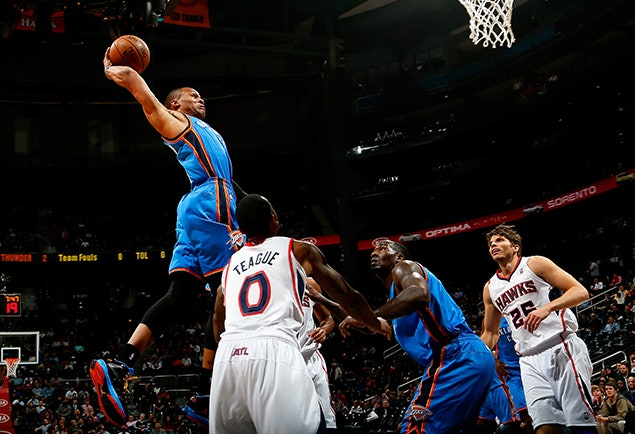

In [ ]:
# load image to test zero-shot classification
url = "https://media.gq.com/photos/55828d111177d66d68d530de/master/w_1600,c_limit/blogs-the-feed-russell-westbrook-gq-fitness-dunk-basketball-sports.jpg"
image = Image.open(requests.get(url, stream=True).raw)

image

In [ ]:
# set device and dtype
dtype = torch.float32
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")
print(f"Using dtype: {dtype}")

Using device: cuda
Using dtype: torch.float32


# Fixed resolution variant

In [ ]:
checkpoint = "google/siglip2-so400m-patch16-384"

model = AutoModel.from_pretrained(checkpoint, torch_dtype=dtype, device_map=device)
processor = AutoProcessor.from_pretrained(checkpoint)

type(model) # Under the hood it's actually SigLIP v1 architecture

transformers.models.siglip.modeling_siglip.SiglipModel

In [ ]:
# labels should be lowercase
labels = [
    "basketball players",          # ✅
    "hawks basketball players",    # ✅
    "lakers basketball players",
    "magic basketball players",
    "thunder basketball players",  # ✅
    "a dunker",                    # ✅
    "football players",
    "volleyball players",
]

# Applying template for zero-shot classification
text = [f"The photo of {label}." for label in labels]

# Preprocessing inputs: resizing and normalizing the image, tokenizing text
inputs = processor(text=text, images=image, padding="max_length", max_length=64)
inputs = inputs.to(device)

with torch.inference_mode():
    outputs = model(**inputs)

# Show resulted probabilities
probs = (outputs.logits_per_text.float().sigmoid().cpu().numpy() * 100)
pd.DataFrame(probs, index=labels).style.format('{:.1f}%').background_gradient('Greens', vmin=0, vmax=100)

,0
basketball players,13.4%
hawks basketball players,66.5%
lakers basketball players,0.3%
magic basketball players,7.2%
thunder basketball players,97.1%
a dunker,11.8%
football players,0.0%
volleyball players,0.0%


The model can not only identify basketball players but also accurately determine the teams they belong to, impressive!

# NaFlex variant

As mentioned earlier, Google also released "NaFlex," a variant that preserves the original image's aspect ratio. This feature can be incredibly useful in scenarios where maintaining the aspect ratio significantly impacts prediction quality.

Let’s explore this with a simple example: imagine an image with a 2:1 aspect ratio containing a circle. In the fixed-resolution variant, resizing the image to a square dimension, such as 224x224 or 384x384, distorts the circle into an ellipse. However, with NaFlex, the original aspect ratio is preserved, and the circle remains intact.

Now, let’s move to a practical demonstration. We'll perform inference to compare how the predicted probabilities differ between the two models.

['A photo of a circle.', 'A photo of an ellipse.', 'A photo of a square.', 'A photo of a rectangle.', 'A photo of a triangle.']


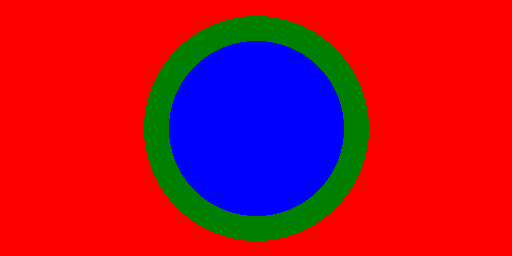

In [ ]:
# first, create an image with a circle and define labels
def create_image(width, height):
    image = Image.new("RGB", (width, height), color="red")
    draw = ImageDraw.Draw(image)
    center_x = image.width // 2
    center_y = image.height // 2
    radius = min(center_x, center_y) // 8 * 7
    draw.ellipse(
        (center_x - radius, center_y - radius, center_x + radius, center_y + radius),
        fill="blue",
        outline="green",
        width=image.width // 20,
    )
    return image

labels = [
    "a circle",
    "an ellipse",
    "a square",
    "a rectangle",
    "a triangle",
]
text = [f"A photo of {label}." for label in labels]
print(text)

image_with_circle = create_image(512, 256)
image_with_circle

In [ ]:
# loading NaFlex model and processor
naflex_checkpoint = "google/siglip2-base-patch16-naflex"

naflex_model = AutoModel.from_pretrained(naflex_checkpoint, torch_dtype=dtype, device_map=device)
naflex_processor = AutoProcessor.from_pretrained(naflex_checkpoint)

In [ ]:
# naflex inference
inputs = naflex_processor(text=text, images=image_with_circle, padding="max_length", max_length=64, return_tensors="pt")
inputs = inputs.to(device)

with torch.inference_mode():
    naflex_outputs = naflex_model(**inputs)

# fixres inference
inputs = processor(text=text, images=image_with_circle, padding="max_length", max_length=64, return_tensors="pt")
inputs = inputs.to(device)

with torch.inference_mode():
    outputs = model(**inputs)

In [ ]:
# visualize results
logits_per_text = torch.cat([naflex_outputs.logits_per_text, outputs.logits_per_text], dim=1)
probs = (logits_per_text.float().sigmoid().detach().cpu().numpy() * 100)

pd.DataFrame(probs, index=labels, columns=["naflex", "fixres"]).style.format('{:.1f}%').background_gradient('Greens', vmin=0, vmax=100)

,naflex,fixres
a circle,66.1%,5.0%
an ellipse,25.7%,69.8%
a square,0.7%,0.8%
a rectangle,2.2%,2.2%
a triangle,0.1%,0.0%


The NaFlex model is significantly more confident that the image contains a circle rather than an ellipse, whereas the FixRes variant predicts the opposite with higher confidence.

### High resolution inference with NaFlex

To increase the image resolution processed by NaFlex variant, simply pass the `max_num_patches` argument to the processor.

By default, this is set to 256 patches of size 16x16 pixels, corresponding to a 256x256 square image or, for example, a 128x512 image. If you increase max_num_patches to 1024, the height and width of the resulting image double, producing a 512x512 or 256x1024 image. No additional changes or flags need to be passed to the model. Here's an example:

In [ ]:
inputs = naflex_processor(text=text, images=image_with_circle, return_tensors="pt")
print(inputs.pixel_values.shape)

inputs_hires = naflex_processor(text=text, images=image_with_circle, return_tensors="pt", max_num_patches=1024)
print(inputs_hires.pixel_values.shape)

# the image is already split to patches and padded to the max_num_patches, so the resulted shape is
# (batch_size, max_num_patches, patch_size ^ 2 * num_channels)

torch.Size([1, 256, 768])
torch.Size([1, 1024, 768])


In [ ]:
with torch.inference_mode():
    naflex_outputs_hires = naflex_model(**inputs_hires.to(device))

probs = (naflex_outputs_hires.logits_per_text.float().sigmoid().cpu().numpy() * 100)
pd.DataFrame(probs, index=labels, columns=["naflex_hires"]).style.format('{:.1f}%').background_gradient('Greens', vmin=0, vmax=100)

,naflex_hires
a circle,77.7%
an ellipse,37.2%
a square,1.8%
a rectangle,4.0%
a triangle,0.2%
